# hurricane-net
Hammad Usmani
### A machine learning algorithm to forecast the intensity and trajectory of Atlantic tropical storms
[https://github.com/hammad93/hurricane-net](https://github.com/hammad93/hurricane-net)

### Table of Contents

1. [Background](#Background)
2. [Problem](#Problem)
3. [Datasets](#Datasets)
4. [Workflow Diagram](#Workflow)
5. [Data Extraction](#Extract)
6. [Data Transformation](#Transform)
7. [Data Loading](#Load)
8. [Feature Engineering](#FeatureEngineering)
9. [Model Architecture](#ModelArchitecture)
11. [Model Selection](#ModelSelection)
12. [Paramater Optimization](#Optimization)
13. [Model Evaluation & Benchmarks](#Benchmarks)
14. [Visualizations](#Visualizations)

![Hurricane Maria 2017](img/hurricane-maria.png "Hurricane Maria. Source: NOAA")

## Background<a id="Background"></a>

The National Hurricane Center (NHC) and National Oceanic and Atmospheric Administration (NOAA) provide predictions for storms trajectories, intensity, and size. They create these predictions based on models that can be classified into 3 groups: dynamical, statistical, and ensemble [1]. The most accurate models are based on computational fluid dynamics and achieve more precision than their statistical and ensemble counterparts [1][4]. The current statistical models (OCD5) are based on multiple regression methods that can explain a significant amount of variance [1]. In this project, we research and implement the domain of machine learning and deep learning into predictive hurricane models for both trajectory and intensity and evaluate them against the NHC standards. 
Previous research into machine learning to forecast tropical Atlantic storms include a sparse recurrent neural network (Kordmahalleh, Sefidmazgi, & Homaifar, 2016) and an artificial neural network (Jung & Das, 2013); both achieved favorable results. The hurricane models created can be utilized to develop more precise emergency planning. There is a necessity for more accurate and timely models that can help reduce the amount of loss caused by hurricanes. 

## Problem<a id="Problem"></a>

The NOAA and NHC have several different classifications for Atlantic hurricane models that describe feature prediction and model architecture. The 3 main classifications for hurricane model architecture include dynamical, statistical, and ensemble. Classifications also include relative compute time required to create an output grouped as either early or late and forecast parameters such as trajectory, intensity, and wind radii. The most accurate models are late models that take upwards of 6 hours to produce an output whereas models that can produce an output in seconds to minutes are called early. Early models tend to be statistical which include the baseline model for trajectory named CLIPER5 Climatology and Persistence (CLP5) utilizing multivariate regression. The performance for these methods can be augmented by incorporating more advanced statistical methods from deep learning such as recurrent neural networks. Kordmahalleh et al., 2016 created a sparse recurrent neural network augmented by a genetic algorithm but there are factors requiring improvement. The training set utilized an older version of the NHC Hurricane Database format known as HURDAT while a new format has been released called HURDAT2 with additional information on wind radii. Kordmahalleh et al., 2016 also utilized benchmarks different from the standard applied within the NHC. Other than improving their methodology, we can expand the scope by creating separate models for both intensity and trajectory. These models can be used to predict the trajectory and intensity for future Atlantic storms.

## Datasets<a id="Datasets"></a>

The following datasets and inputs including their sources will be used to create machine learning models:
- NHC Hurricane Database (HURDAT2)
    - http://www.nhc.noaa.gov/data/#hurdat
    - https://www.kaggle.com/noaa/hurricane-database
- NHC Forecast Error Database
    - http://www.nhc.noaa.gov/verification/verify7.shtml
- NHC GIS
    - http://www.nhc.noaa.gov/gis/

*In the future, the IBTrACS database will be used to extend the hurricane-ai to additional regions.*

The NHC HURDAT2 database contains the tracking information for Atlantic tropical and subtropical cyclones which includes hurricanes and tropical storms from 1851 to 2016. The most updated version of the dataset is included on the noaa.gov site and includes 2 additional years of cyclone data compared to the data set available on Kaggle and is potentially more descriptive. To match the inputs of the baseline model used by the NHC, we are calculating the forward motion of the storm by applying a vector based on previous and current geographical location.

*Table 1. This table contains the tentative features as input to the model*

| **Name**         | **Data Type** | **Description**                                                     |
|------------------|---------------|---------------------------------------------------------------------|
| Time             | Date Time     | The date and time of the measurement.                               |
| Latitude         | Float         | The geographical latitude of the storm eye to 1 decimal precision.  |
| Longitude        | Float         | The geographical longitude of the storm eye to 1 decimal precision. |
| Maximum Winds    | Integer       | The maximum sustained winds within the storm.                       |
| Minimum Pressure | Integer       | The minimum barometric pressure within the storm.                   |
| Forward Motion   | String        | Calculated vector of motion based on location in time series.       |

The Forecast Error Database contains information on the accuracy of predicted models from the NHC. The two model forecast errors available are labeled OFCL and BCD5. The OFCL is the official NHC forecast and the BCD5 is the real track available. This data set can be used to benchmark and evaluate the deep learning model. 
The NOAA and NHC also hosts a geographical information system (GIS) that contains raw and processed data on hurricanes. The server hosting the GIS is publicly accessible and can be used to evaluate our model by comparing the 2017 Atlantic tropical season. The preliminary best tracks can be found here before they are finalized and available in the HURDAT2 data set. With the GIS, we can construct a final evaluation data set.

*Diagram 1. This graphic describes the workflow for the deep learning models*.<a id="Workflow"></a>
![Data Pipeline](img/Deep Learning Workflow.png "hurricane-net Data Pipeline")

## Extract Data<a id="Extract"></a>

*The following code uses the hurdat2 and models modules created to provide a class interface for the HURDAT2 and error forecast database located in the data and models folder. *

We will begin our steps to perform extraction, transformation, and loading of our data for analysis or broadly known as ETL. Although we're dividing these steps into disctinct procedures, they are often more fluid and often have overlaps. The extraction phase consists of collecting and parsing the HURDAT2 and error forecast databases for analysis and benchmarking. The HURDAT2 database is our core foundation for creating the deep learning model. We store the database in its raw .txt format but it can be directly linked to the database hosted by the NHC.

In [1]:
# Import various libraries throughout the software
from pprint import pprint
import numpy as np
import datetime
import dateutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Import from hurdat2 class in data folder and models class from hurricane-models folder
from data.hurdat2 import hurdat2
from errors.models import models

# Initialize Dataframe for hurricanes and error database
dataset = hurdat2("data/hurdat2.txt")
errors = models("errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt")

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.hurricanes.query('storm_id == "AL122005"').head()

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44063,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44064,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44065,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44066,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44067,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(errors.models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): 0.0,
                                      datetime.datetime(2005, 8, 29, 6, 0): 20.9,
                                      datetime.datetime(2005, 8, 29, 18, 0): 93.6,
                                      datetime.datetime(2005, 8, 30, 6, 0): 170.2,
                                      datetime.datetime(2005, 8, 30, 18, 0): None,
                                      datetime.datetime(2005, 8, 31, 18, 0): None,
                                      datetime.datetime(2005, 9, 1, 18, 0): None,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 26.3,
        'long': 88.6,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 

## Transform Data<a id="Transform"></a>

The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a `storm_id` dictionary to store storm names matched with ID's.

In [3]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : None if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return
# Storm ID Key for matching between datasets
storm_ids = dict()

# Parse in hurricanes
hurricanes = dict()
print("Transforming HURDAT2 into objects . . .")
for index, entry in dataset.hurricanes.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming HURDAT2 into objects . . .
Transforming 49691/49691 entries from HURDAT2
Done!


## Load Data<a id="Load"></a>

The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [4]:
# Get all available model errors
models = errors.models.keys()
# Load model errors into hurricanes
for id in storm_ids :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in errors.models[model].storm :
            continue
        hurricanes[id].add_model(model, errors.models[model].storm[id])

## Feature Engineering & Data Augmentation<a id="FeatureEngineering"></a>

The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.

1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [5]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'], 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
    }
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
        x.append(sample) # Add our constructed sample
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) is 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 11) where 11 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Feature engineered 1830/1830 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1830/1830 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


## Model Architecture<a id="ModelArchitecture"></a>

Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

Notes:
- We will use 500 epochs for wind intensity because the validation loss is not decresing
- We will use 1,000 epochs for latitute and longitude

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)

# Train for wind intensity
y_train_wind = np.array([[[features[2]] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2]] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)


def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 1024, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 512, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mae', optimizer='adam')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

def lstm_td(X_train, X_test, y_train, y_test) :
    model = Sequential()
    model.add(LSTM(units = 1024, input_shape = (5,8), return_sequences = True))
    model.add(TimeDistributed(Dense(8)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    model.fit(X_train, y_train, batch_size = len(X_train), epochs = 300)
    
    return model

model_wind, model_wind_history = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind)
model_lat, model_lat_history = bd_lstm_td(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 1000)
model_long, model_long_history = bd_lstm_td(X_train, y_train_long, X_test, y_test_long, n_epochs = 1000)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 2048)           8486912   
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 512)            5244928   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              513       
Total params: 13,732,353
Trainable params: 13,732,353
Non-trainable params: 0
_________________________________________________________________
None
Train on 3298 samples, validate on 825 samples
Epoch 1/500
3298/3298 [==============================] - 8s 2ms/step - loss: 0.7130 - val_loss: 0.5943
Epoch 2/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.6070 - val_loss: 0.5776
Epoch 3/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.5778 - val_loss: 0.5555
Epoch 4/500
3298/3298 [==========

Epoch 73/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4102 - val_loss: 0.4185
Epoch 74/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4100 - val_loss: 0.4193
Epoch 75/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4085 - val_loss: 0.4197
Epoch 76/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4083 - val_loss: 0.4149
Epoch 77/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4050 - val_loss: 0.4166
Epoch 78/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4035 - val_loss: 0.4144
Epoch 79/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4022 - val_loss: 0.4124
Epoch 80/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4023 - val_loss: 0.4137
Epoch 81/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.4027 - val_loss: 0.4096
Epoch 82/500
3298/3298 [==============================] - 4s 1ms

Epoch 152/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.3042 - val_loss: 0.3164
Epoch 153/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2987 - val_loss: 0.3122
Epoch 154/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2985 - val_loss: 0.3204
Epoch 155/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.3009 - val_loss: 0.3138
Epoch 156/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2922 - val_loss: 0.3111
Epoch 157/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2913 - val_loss: 0.3090
Epoch 158/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2864 - val_loss: 0.3082
Epoch 159/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2926 - val_loss: 0.3097
Epoch 160/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2880 - val_loss: 0.3011
Epoch 161/500
3298/3298 [==============================

3298/3298 [==============================] - 4s 1ms/step - loss: 0.1842 - val_loss: 0.1989
Epoch 231/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1835 - val_loss: 0.1980
Epoch 232/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1869 - val_loss: 0.1996
Epoch 233/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1887 - val_loss: 0.1979
Epoch 234/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1880 - val_loss: 0.2004
Epoch 235/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1850 - val_loss: 0.1953
Epoch 236/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1850 - val_loss: 0.2082
Epoch 237/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1887 - val_loss: 0.1960
Epoch 238/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1848 - val_loss: 0.1933
Epoch 239/500
3298/3298 [==============================] - 4s 1ms/ste

Epoch 309/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1383 - val_loss: 0.1566
Epoch 310/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1340 - val_loss: 0.1580
Epoch 311/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1367 - val_loss: 0.1560
Epoch 312/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1401 - val_loss: 0.1627
Epoch 313/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1413 - val_loss: 0.1561
Epoch 314/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1437 - val_loss: 0.1571
Epoch 315/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1372 - val_loss: 0.1566
Epoch 316/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1378 - val_loss: 0.1543
Epoch 317/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1371 - val_loss: 0.1569
Epoch 318/500
3298/3298 [==============================

3298/3298 [==============================] - 4s 1ms/step - loss: 0.1114 - val_loss: 0.1393
Epoch 388/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1176 - val_loss: 0.1491
Epoch 389/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1161 - val_loss: 0.1407
Epoch 390/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1187 - val_loss: 0.1436
Epoch 391/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1130 - val_loss: 0.1391
Epoch 392/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1081 - val_loss: 0.1377
Epoch 393/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1103 - val_loss: 0.1451
Epoch 394/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1148 - val_loss: 0.1382
Epoch 395/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1137 - val_loss: 0.1456
Epoch 396/500
3298/3298 [==============================] - 4s 1ms/ste

Epoch 466/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0930 - val_loss: 0.1332
Epoch 467/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0950 - val_loss: 0.1315
Epoch 468/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0958 - val_loss: 0.1299
Epoch 469/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0914 - val_loss: 0.1296
Epoch 470/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0914 - val_loss: 0.1284
Epoch 471/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0935 - val_loss: 0.1361
Epoch 472/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0985 - val_loss: 0.1294
Epoch 473/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0931 - val_loss: 0.1327
Epoch 474/500
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0945 - val_loss: 0.1286
Epoch 475/500
3298/3298 [==============================

Epoch 37/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2632 - val_loss: 0.2591
Epoch 38/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2673 - val_loss: 0.2585
Epoch 39/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.2632 - val_loss: 0.2585
Epoch 40/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2639 - val_loss: 0.2598
Epoch 41/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2640 - val_loss: 0.2580
Epoch 42/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2625 - val_loss: 0.2559
Epoch 43/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2611 - val_loss: 0.2558
Epoch 44/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.2616 - val_loss: 0.2560
Epoch 45/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.2602 - val_loss: 0.2561
Epoch 46/1000
3298/3298 [==============================

Epoch 115/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2318 - val_loss: 0.2323
Epoch 116/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2340 - val_loss: 0.2306
Epoch 117/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2305 - val_loss: 0.2315
Epoch 118/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2306 - val_loss: 0.2289
Epoch 119/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.2290 - val_loss: 0.2296
Epoch 120/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2294 - val_loss: 0.2275
Epoch 121/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2290 - val_loss: 0.2300
Epoch 122/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.2302 - val_loss: 0.2264
Epoch 123/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.2265 - val_loss: 0.2273
Epoch 124/1000
3298/3298 [====================

Epoch 193/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1883 - val_loss: 0.1891
Epoch 194/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1857 - val_loss: 0.1888
Epoch 195/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1858 - val_loss: 0.1941
Epoch 196/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1886 - val_loss: 0.1892
Epoch 197/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1850 - val_loss: 0.1903
Epoch 198/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1855 - val_loss: 0.1886
Epoch 199/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1839 - val_loss: 0.1870
Epoch 200/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1836 - val_loss: 0.1912
Epoch 201/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1848 - val_loss: 0.1889
Epoch 202/1000
3298/3298 [====================

Epoch 271/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1397 - val_loss: 0.1385
Epoch 272/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1402 - val_loss: 0.1403
Epoch 273/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1384 - val_loss: 0.1425
Epoch 274/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1397 - val_loss: 0.1398
Epoch 275/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1408 - val_loss: 0.1427
Epoch 276/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1382 - val_loss: 0.1418
Epoch 277/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1414 - val_loss: 0.1395
Epoch 278/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1386 - val_loss: 0.1426
Epoch 279/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1391 - val_loss: 0.1374
Epoch 280/1000
3298/3298 [====================

Epoch 349/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1067 - val_loss: 0.1075
Epoch 350/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1072 - val_loss: 0.1009
Epoch 351/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1051 - val_loss: 0.1035
Epoch 352/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1033 - val_loss: 0.1001
Epoch 353/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1057 - val_loss: 0.1009
Epoch 354/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1004 - val_loss: 0.1008
Epoch 355/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0990 - val_loss: 0.0971
Epoch 356/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1005 - val_loss: 0.1037
Epoch 357/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1019 - val_loss: 0.0996
Epoch 358/1000
3298/3298 [====================

Epoch 427/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0837 - val_loss: 0.0810
Epoch 428/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0803 - val_loss: 0.0821
Epoch 429/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0808 - val_loss: 0.0834
Epoch 430/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0818 - val_loss: 0.0824
Epoch 431/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0838 - val_loss: 0.0805
Epoch 432/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0791 - val_loss: 0.0807
Epoch 433/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0805 - val_loss: 0.0791
Epoch 434/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0792 - val_loss: 0.0781
Epoch 435/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0784 - val_loss: 0.0797
Epoch 436/1000
3298/3298 [====================

Epoch 505/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0695 - val_loss: 0.0739
Epoch 506/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0717 - val_loss: 0.0715
Epoch 507/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0701 - val_loss: 0.0710
Epoch 508/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0710 - val_loss: 0.0700
Epoch 509/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0686 - val_loss: 0.0697
Epoch 510/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0694 - val_loss: 0.0714
Epoch 511/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0678 - val_loss: 0.0679
Epoch 512/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0689 - val_loss: 0.0704
Epoch 513/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0690 - val_loss: 0.0722
Epoch 514/1000
3298/3298 [====================

Epoch 583/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0658 - val_loss: 0.0687
Epoch 584/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0662 - val_loss: 0.0628
Epoch 585/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0600 - val_loss: 0.0639
Epoch 586/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0640 - val_loss: 0.0711
Epoch 587/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0651 - val_loss: 0.0653
Epoch 588/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0624 - val_loss: 0.0630
Epoch 589/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0638 - val_loss: 0.0726
Epoch 590/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0678 - val_loss: 0.0623
Epoch 591/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0626 - val_loss: 0.0618
Epoch 592/1000
3298/3298 [====================

Epoch 661/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0559 - val_loss: 0.0580
Epoch 662/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0548 - val_loss: 0.0600
Epoch 663/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0555 - val_loss: 0.0596
Epoch 664/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0547 - val_loss: 0.0570
Epoch 665/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0540 - val_loss: 0.0606
Epoch 666/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0564 - val_loss: 0.0602
Epoch 667/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0575 - val_loss: 0.0610
Epoch 668/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0561 - val_loss: 0.0636
Epoch 669/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0590 - val_loss: 0.0604
Epoch 670/1000
3298/3298 [====================

Epoch 739/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0532 - val_loss: 0.0554
Epoch 740/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0519 - val_loss: 0.0584
Epoch 741/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0501 - val_loss: 0.0547
Epoch 742/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0528 - val_loss: 0.0615
Epoch 743/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0547 - val_loss: 0.0584
Epoch 744/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0525 - val_loss: 0.0571
Epoch 745/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0549 - val_loss: 0.0585
Epoch 746/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0514 - val_loss: 0.0557
Epoch 747/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0517 - val_loss: 0.0570
Epoch 748/1000
3298/3298 [====================

Epoch 817/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0471 - val_loss: 0.0545
Epoch 818/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0484 - val_loss: 0.0542
Epoch 819/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0485 - val_loss: 0.0589
Epoch 820/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0493 - val_loss: 0.0551
Epoch 821/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0481 - val_loss: 0.0534
Epoch 822/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0474 - val_loss: 0.0591
Epoch 823/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0489 - val_loss: 0.0526
Epoch 824/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0477 - val_loss: 0.0545
Epoch 825/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0485 - val_loss: 0.0585
Epoch 826/1000
3298/3298 [====================

Epoch 895/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0424 - val_loss: 0.0541
Epoch 896/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0451 - val_loss: 0.0532
Epoch 897/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0431 - val_loss: 0.0538
Epoch 898/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0454 - val_loss: 0.0532
Epoch 899/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0447 - val_loss: 0.0506
Epoch 900/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0417 - val_loss: 0.0541
Epoch 901/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0445 - val_loss: 0.0521
Epoch 902/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0430 - val_loss: 0.0522
Epoch 903/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0439 - val_loss: 0.0534
Epoch 904/1000
3298/3298 [====================

Epoch 973/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0439 - val_loss: 0.0547
Epoch 974/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0422 - val_loss: 0.0504
Epoch 975/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0424 - val_loss: 0.0543
Epoch 976/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0411 - val_loss: 0.0517
Epoch 977/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0412 - val_loss: 0.0528
Epoch 978/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0429 - val_loss: 0.0542
Epoch 979/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0421 - val_loss: 0.0503
Epoch 980/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0419 - val_loss: 0.0530
Epoch 981/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0406 - val_loss: 0.0513
Epoch 982/1000
3298/3298 [====================

Epoch 44/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1914 - val_loss: 0.1731
Epoch 45/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1870 - val_loss: 0.1730
Epoch 46/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1866 - val_loss: 0.1731
Epoch 47/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1879 - val_loss: 0.1730
Epoch 48/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1881 - val_loss: 0.1723
Epoch 49/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1877 - val_loss: 0.1724
Epoch 50/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1868 - val_loss: 0.1725
Epoch 51/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1897 - val_loss: 0.1722
Epoch 52/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1879 - val_loss: 0.1714
Epoch 53/1000
3298/3298 [==============================

Epoch 122/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1704 - val_loss: 0.1555
Epoch 123/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1696 - val_loss: 0.1549
Epoch 124/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1712 - val_loss: 0.1534
Epoch 125/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1684 - val_loss: 0.1543
Epoch 126/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1700 - val_loss: 0.1544
Epoch 127/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1683 - val_loss: 0.1532
Epoch 128/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1688 - val_loss: 0.1532
Epoch 129/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1654 - val_loss: 0.1534
Epoch 130/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1653 - val_loss: 0.1524
Epoch 131/1000
3298/3298 [====================

Epoch 200/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1411 - val_loss: 0.1320
Epoch 201/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1434 - val_loss: 0.1322
Epoch 202/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1455 - val_loss: 0.1318
Epoch 203/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1413 - val_loss: 0.1270
Epoch 204/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1400 - val_loss: 0.1276
Epoch 205/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1381 - val_loss: 0.1317
Epoch 206/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1409 - val_loss: 0.1280
Epoch 207/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1412 - val_loss: 0.1282
Epoch 208/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1388 - val_loss: 0.1254
Epoch 209/1000
3298/3298 [====================

Epoch 278/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1044 - val_loss: 0.0969
Epoch 279/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1061 - val_loss: 0.1024
Epoch 280/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1081 - val_loss: 0.1010
Epoch 281/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1057 - val_loss: 0.0950
Epoch 282/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1051 - val_loss: 0.0993
Epoch 283/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1049 - val_loss: 0.0944
Epoch 284/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1056 - val_loss: 0.1023
Epoch 285/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.1078 - val_loss: 0.1030
Epoch 286/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.1071 - val_loss: 0.0984
Epoch 287/1000
3298/3298 [====================

Epoch 356/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0797 - val_loss: 0.0770
Epoch 357/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0829 - val_loss: 0.0831
Epoch 358/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0833 - val_loss: 0.0752
Epoch 359/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0806 - val_loss: 0.0770
Epoch 360/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0808 - val_loss: 0.0772
Epoch 361/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0791 - val_loss: 0.0750
Epoch 362/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0806 - val_loss: 0.0802
Epoch 363/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0797 - val_loss: 0.0747
Epoch 364/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0816 - val_loss: 0.0774
Epoch 365/1000
3298/3298 [====================

Epoch 434/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0655 - val_loss: 0.0629
Epoch 435/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0640 - val_loss: 0.0648
Epoch 436/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0663 - val_loss: 0.0638
Epoch 437/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0649 - val_loss: 0.0641
Epoch 438/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0669 - val_loss: 0.0679
Epoch 439/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0698 - val_loss: 0.0648
Epoch 440/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0674 - val_loss: 0.0678
Epoch 441/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0687 - val_loss: 0.0596
Epoch 442/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0652 - val_loss: 0.0622
Epoch 443/1000
3298/3298 [====================

Epoch 512/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0549 - val_loss: 0.0602
Epoch 513/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0579 - val_loss: 0.0530
Epoch 514/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0563 - val_loss: 0.0603
Epoch 515/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0577 - val_loss: 0.0553
Epoch 516/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0557 - val_loss: 0.0544
Epoch 517/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0554 - val_loss: 0.0562
Epoch 518/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0543 - val_loss: 0.0547
Epoch 519/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0551 - val_loss: 0.0582
Epoch 520/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0581 - val_loss: 0.0526
Epoch 521/1000
3298/3298 [====================

Epoch 590/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0502 - val_loss: 0.0498
Epoch 591/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0502 - val_loss: 0.0515
Epoch 592/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0486 - val_loss: 0.0501
Epoch 593/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0476 - val_loss: 0.0499
Epoch 594/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0490 - val_loss: 0.0522
Epoch 595/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0487 - val_loss: 0.0491
Epoch 596/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0491 - val_loss: 0.0523
Epoch 597/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0500 - val_loss: 0.0483
Epoch 598/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0473 - val_loss: 0.0511
Epoch 599/1000
3298/3298 [====================

Epoch 668/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0466 - val_loss: 0.0442
Epoch 669/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0449 - val_loss: 0.0483
Epoch 670/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0432 - val_loss: 0.0478
Epoch 671/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0450 - val_loss: 0.0452
Epoch 672/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0452 - val_loss: 0.0493
Epoch 673/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0437 - val_loss: 0.0449
Epoch 674/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0436 - val_loss: 0.0517
Epoch 675/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0460 - val_loss: 0.0504
Epoch 676/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0481 - val_loss: 0.0496
Epoch 677/1000
3298/3298 [====================

Epoch 746/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0397 - val_loss: 0.0473
Epoch 747/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0409 - val_loss: 0.0432
Epoch 748/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0429 - val_loss: 0.0493
Epoch 749/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0431 - val_loss: 0.0467
Epoch 750/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0398 - val_loss: 0.0414
Epoch 751/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0403 - val_loss: 0.0521
Epoch 752/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0454 - val_loss: 0.0446
Epoch 753/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0396 - val_loss: 0.0431
Epoch 754/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0418 - val_loss: 0.0539
Epoch 755/1000
3298/3298 [====================

Epoch 824/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0397 - val_loss: 0.0426
Epoch 825/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0391 - val_loss: 0.0423
Epoch 826/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0376 - val_loss: 0.0442
Epoch 827/1000
3298/3298 [==============================] - 4s 1ms/step - loss: 0.0372 - val_loss: 0.0413
Epoch 828/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0365 - val_loss: 0.0429
Epoch 829/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0369 - val_loss: 0.0444
Epoch 830/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0382 - val_loss: 0.0431
Epoch 831/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0389 - val_loss: 0.0435
Epoch 832/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0371 - val_loss: 0.0435
Epoch 833/1000
3298/3298 [====================

Epoch 902/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0371 - val_loss: 0.0441
Epoch 903/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0356 - val_loss: 0.0407
Epoch 904/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0347 - val_loss: 0.0420
Epoch 905/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0340 - val_loss: 0.0402
Epoch 906/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0342 - val_loss: 0.0427
Epoch 907/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0340 - val_loss: 0.0397
Epoch 908/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0337 - val_loss: 0.0419
Epoch 909/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0343 - val_loss: 0.0426
Epoch 910/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0340 - val_loss: 0.0413
Epoch 911/1000
3298/3298 [====================

Epoch 980/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0342 - val_loss: 0.0440
Epoch 981/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0384 - val_loss: 0.0432
Epoch 982/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0355 - val_loss: 0.0407
Epoch 983/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0337 - val_loss: 0.0397
Epoch 984/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0308 - val_loss: 0.0434
Epoch 985/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0347 - val_loss: 0.0443
Epoch 986/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0387 - val_loss: 0.0436
Epoch 987/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0352 - val_loss: 0.0415
Epoch 988/1000
3298/3298 [==============================] - 3s 1ms/step - loss: 0.0320 - val_loss: 0.0403
Epoch 989/1000
3298/3298 [====================

## Model Selection<a id="Selection"></a>
The following models were compared
- Bidirectional LSTM with Time Distributed(Best performance)
- LSTM with Time Distributed
- MLP
- Bidirectional GRU with Time Distributed

Wind


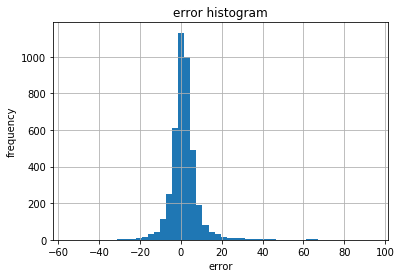

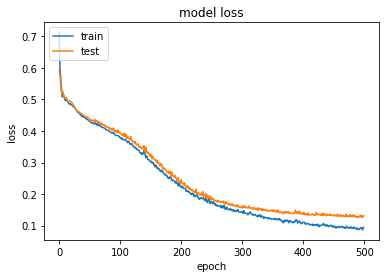

,0
count,4125.000000
mean,1.584944
std,7.348481
min,-54.980289
25%,-1.514354
50%,1.259278
75%,4.137563
max,94.064836


In [7]:
def ai_errors(predictions, observations, history = None) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
             history - Keras history model for displaying model loss, default is None if not available
    OUTPUT:
    '''
    errors = []
    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors
            error = predictions[i][j] - observations[i][j]
            errors.append(error)
    
    # Display history and erros
    plt.figure(1)
    plt.hist(errors, bins = 50)
    plt.title('error histogram')
    plt.xlabel('error')
    plt.ylabel('frequency')
    plt.grid(True)
    
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return pd.DataFrame(errors)

# Predict values
wind_predictions = model_wind.predict(X_test)
lat_predictions = model_lat.predict(X_test)
long_predictions = model_long.predict(X_test)

# Scale back our predictions
# Wind
wind_predictions_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in prediction])
                           for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in observation])
                      for observation in y_test_wind]
# Latitude
lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0] for lat in prediction])
                          for prediction in lat_predictions]
y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0] for lat in observation])
                     for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0] for long in prediction])
                           for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0] for long in observation])
                      for observation in y_test_long]

# Record wind predictions and observations
print("Wind")
wind_predictions = [[pred[2] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[2] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]

# Present Errors
ai_errors(wind_predictions, wind_observations, model_wind_history).describe()

Lat


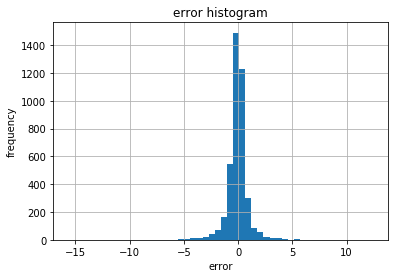

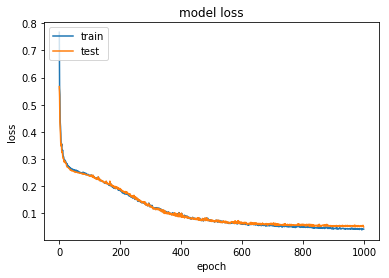

,0
count,4125.000000
mean,-0.051482
std,1.126631
min,-15.624830
25%,-0.403594
50%,-0.001016
75%,0.316122
max,12.430341


In [8]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
ai_errors(lat_predictions, lat_observations, model_lat_history).describe()

Long


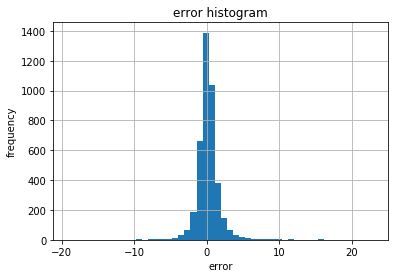

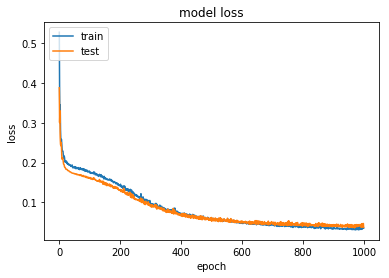

,0
count,4125.000000
mean,0.227495
std,1.848078
min,-19.020159
25%,-0.521418
50%,0.090338
75%,0.792636
max,22.946886


In [9]:
print("Long")
long_predictions = [[pred[1] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[1] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
ai_errors(long_predictions, long_observations, model_long_history).describe()

## Model Evaluation & Benchmarks<a id="Benchmarks"></a>

The machine learning neural network will use 2 main methods of applied evaluation. The first will be evaluated compared to the other models that predict Atlantic hurricanes. The forecast errors have been loaded into each hurricane object corresponding to their forecast model; both the OFCL (official track) and the BCD5 (model using multivariate regression). The BCD5 model is "the CLP5 (track) and DSF5 (intensity) models merged" that uses the best track as input.

In [10]:
# Filter storms that have more than 6 entries. We need at least 6 to calculate 5 speed vectors
storms_filter = [storm for storm in hurricanes.values() if len(storm.entries) > 6]

# Begin creating hurricane forecast and track predictions
tracks = {
    'storms' : [], # Reference storm
    'inputs' : [], # The inputs for the ai
    'valid_times' : [], # The valid time to compare to the error database
}
for index, storm in enumerate(storms_filter) :
    # Create inputs to ai. ai requires scaled data as input
    entries = [entry[1] for entry in sorted(storm.entries.items())] # Extracts data from data structure
    
    # Scale the entries
    for start_index in range(1, len(entries) - 5) : # Go through each entry
        # Build feature extraction
        extracted_features = []
        valid_time = None # Going to be set to the last element in the series
        for pivot in range(start_index, start_index + 5) :
            extracted_features.append(np.array(list(feature_extraction(entries[pivot], entries[pivot - 1]).values())))
            if pivot is start_index + 4 : # We're on the last element
                valid_time = entries[pivot]['entry_time']
        
        # If there's an incomplete value we can't process, skip it
        if any(None in entry for entry in extracted_features) :
            continue
            
        # Scale extracted features        
        scaled_entries = scaler.transform(extracted_features)
        
        # Add to our results
        tracks['storms'].append(storm)
        tracks['inputs'].append(scaled_entries.tolist())
        tracks['valid_times'].append(valid_time)
        
    print("\rDone with track processing {}/{} storms".format(index + 1, len(storms_filter)), end = '')
tracks['inputs'] = np.array(tracks['inputs'])

Done with track processing 1745/1745 storms

In [11]:
tracks['wind_predictions_raw'] = model_wind.predict(tracks['inputs'])

In [12]:
# Scale back and store our wind predictions
tracks['wind_predictions'] = []
for index, prediction in enumerate(tracks['wind_predictions_raw']) :
    # Use our standard scaler to scale the raw predictions back
    winds_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in prediction])]
    
    # Extract the wind prediction from data structure and store into new data structure
    for hurricanes_pred in winds_scaled :        
        # The new data structure is a tuple of (wind, storm_id, valid_time, forecast_time)
        wind_predictions = []
        for step, pred in enumerate(hurricanes_pred) :
            wind = pred[2]
            storm_id = tracks['storms'][index].id
            valid_time = tracks['valid_times'][index]
            forecast_time = valid_time + datetime.timedelta(days = step + 1)
            
            # See if we can find the error
            if forecast_time in hurricanes[storm_id].entries :
                truth = hurricanes[storm_id].entries[forecast_time]['max_wind']
                print("Forecast: {} Truth: {} Error: {}".format(wind, truth, truth - wind))
            wind_predictions.append((wind, storm_id, valid_time, forecast_time))
        tracks['wind_predictions'].append(wind_predictions)

Forecast: 59.572027027606964 Truth: 30.0 Error: -29.572027027606964
Forecast: 39.414886459708214 Truth: 25.0 Error: -14.414886459708214
Forecast: 68.73571306467056 Truth: 35.0 Error: -33.73571306467056
Forecast: 72.37013578414917 Truth: 40.0 Error: -32.37013578414917
Forecast: 68.80480259656906 Truth: 45.0 Error: -23.80480259656906
Forecast: 58.548366874456406 Truth: 45.0 Error: -13.548366874456406
Forecast: 49.67374578118324 Truth: 45.0 Error: -4.673745781183243
Forecast: 75.73789060115814 Truth: 40.0 Error: -35.73789060115814
Forecast: 70.96649676561356 Truth: 45.0 Error: -25.966496765613556
Forecast: 58.32592040300369 Truth: 45.0 Error: -13.325920403003693
Forecast: 50.960817858576775 Truth: 40.0 Error: -10.960817858576775
Forecast: 73.06566447019577 Truth: 45.0 Error: -28.06566447019577
Forecast: 69.29919391870499 Truth: 45.0 Error: -24.299193918704987
Forecast: 56.77242085337639 Truth: 50.0 Error: -6.7724208533763885
Forecast: 50.7441333681345 Truth: 30.0 Error: -20.7441333681345


Forecast: 25.730687975883484 Truth: 25.0 Error: -0.7306879758834839
Forecast: 30.504091829061508 Truth: 25.0 Error: -5.504091829061508
Forecast: 61.26413851976395 Truth: 40.0 Error: -21.264138519763947
Forecast: 84.49473321437836 Truth: 65.0 Error: -19.494733214378357
Forecast: 82.53584325313568 Truth: 90.0 Error: 7.464156746864319
Forecast: 25.690929889678955 Truth: 25.0 Error: -0.6909298896789551
Forecast: 36.299318447709084 Truth: 25.0 Error: -11.299318447709084
Forecast: 67.25575178861618 Truth: 50.0 Error: -17.25575178861618
Forecast: 88.90316605567932 Truth: 70.0 Error: -18.90316605567932
Forecast: 66.20437175035477 Truth: 55.0 Error: -11.204371750354767
Forecast: 26.056882441043854 Truth: 25.0 Error: -1.0568824410438538
Forecast: 40.34798942506313 Truth: 30.0 Error: -10.347989425063133
Forecast: 67.45173841714859 Truth: 65.0 Error: -2.45173841714859
Forecast: 91.30812764167786 Truth: 100.0 Error: 8.691872358322144
Forecast: 47.156042624264956 Truth: 30.0 Error: -17.1560426242649

Forecast: 31.257794201374054 Truth: 25.0 Error: -6.257794201374054
Forecast: 17.217029333114624 Truth: 20.0 Error: 2.782970666885376
Forecast: 18.01553100347519 Truth: 20.0 Error: 1.9844689965248108
Forecast: 19.6486833691597 Truth: 20.0 Error: 0.3513166308403015
Forecast: 27.290417850017548 Truth: 25.0 Error: -2.2904178500175476
Forecast: 27.283414602279663 Truth: 25.0 Error: -2.283414602279663
Forecast: 20.251605212688446 Truth: 20.0 Error: -0.25160521268844604
Forecast: 21.320283710956573 Truth: 20.0 Error: -1.3202837109565735
Forecast: 21.22731178998947 Truth: 20.0 Error: -1.2273117899894714
Forecast: 28.342084735631943 Truth: 25.0 Error: -3.3420847356319427
Forecast: 26.070805490016937 Truth: 25.0 Error: -1.0708054900169373
Forecast: 19.792332351207733 Truth: 20.0 Error: 0.20766764879226685
Forecast: 22.385830879211426 Truth: 20.0 Error: -2.385830879211426
Forecast: 21.025746762752533 Truth: 20.0 Error: -1.025746762752533
Forecast: 44.98935678973794 Truth: 25.0 Error: -19.98935678

Forecast: 88.77172112464905 Truth: 90.0 Error: 1.2282788753509521
Forecast: 77.73096233606339 Truth: 80.0 Error: 2.269037663936615
Forecast: 77.32177406549454 Truth: 75.0 Error: -2.3217740654945374
Forecast: 93.762326836586 Truth: 90.0 Error: -3.7623268365859985
Forecast: 96.17426037788391 Truth: 90.0 Error: -6.174260377883911
Forecast: 87.47665643692017 Truth: 85.0 Error: -2.476656436920166
Forecast: 76.0717099905014 Truth: 80.0 Error: 3.928290009498596
Forecast: 77.77617365121841 Truth: 70.0 Error: -7.776173651218414
Forecast: 94.78041589260101 Truth: 90.0 Error: -4.780415892601013
Forecast: 95.30996322631836 Truth: 90.0 Error: -5.309963226318359
Forecast: 86.10837996006012 Truth: 80.0 Error: -6.10837996006012
Forecast: 76.39817982912064 Truth: 80.0 Error: 3.601820170879364
Forecast: 77.58881121873856 Truth: 65.0 Error: -12.588811218738556
Forecast: 92.29230403900146 Truth: 90.0 Error: -2.292304039001465
Forecast: 90.50291895866394 Truth: 90.0 Error: -0.5029189586639404
Forecast: 86.

Forecast: 43.30381305888295 Truth: 45.0 Error: 1.6961869411170483
Forecast: 74.14781957864761 Truth: 60.0 Error: -14.147819578647614
Forecast: 56.298454105854034 Truth: 45.0 Error: -11.298454105854034
Forecast: 40.25999404489994 Truth: 45.0 Error: 4.7400059551000595
Forecast: 73.72502952814102 Truth: 60.0 Error: -13.725029528141022
Forecast: 59.158869832754135 Truth: 45.0 Error: -14.158869832754135
Forecast: 73.04861217737198 Truth: 55.0 Error: -18.04861217737198
Forecast: 60.05627125501633 Truth: 45.0 Error: -15.056271255016327
Forecast: 65.94143182039261 Truth: 50.0 Error: -15.941431820392609
Forecast: 56.719294637441635 Truth: 45.0 Error: -11.719294637441635
Forecast: 64.89077359437943 Truth: 45.0 Error: -19.890773594379425
Forecast: 61.142647713422775 Truth: 45.0 Error: -16.142647713422775
Forecast: 62.88893789052963 Truth: 45.0 Error: -17.888937890529633
Forecast: 60.77623099088669 Truth: 45.0 Error: -15.776230990886688
Forecast: 59.917377680540085 Truth: 45.0 Error: -14.917377680

Forecast: 60.45956403017044 Truth: 40.0 Error: -20.45956403017044
Forecast: 59.93822991847992 Truth: 60.0 Error: 0.061770081520080566
Forecast: 60.394569635391235 Truth: 40.0 Error: -20.394569635391235
Forecast: 59.944353848695755 Truth: 45.0 Error: -14.944353848695755
Forecast: 59.95471999049187 Truth: 40.0 Error: -19.954719990491867
Forecast: 60.3342179954052 Truth: 40.0 Error: -20.334217995405197
Forecast: 59.09276559948921 Truth: 40.0 Error: -19.092765599489212
Forecast: 48.82747046649456 Truth: 45.0 Error: -3.8274704664945602
Forecast: 62.852371633052826 Truth: 75.0 Error: 12.147628366947174
Forecast: 29.01115357875824 Truth: 40.0 Error: 10.98884642124176
Forecast: 27.116327583789825 Truth: 30.0 Error: 2.8836724162101746
Forecast: 23.29901933670044 Truth: 25.0 Error: 1.7009806632995605
Forecast: 61.696410179138184 Truth: 50.0 Error: -11.696410179138184
Forecast: 53.67075450718403 Truth: 80.0 Error: 26.32924549281597
Forecast: 23.979794681072235 Truth: 30.0 Error: 6.020205318927765

Forecast: 41.1455325037241 Truth: 45.0 Error: 3.854467496275902
Forecast: 34.623941630125046 Truth: 35.0 Error: 0.3760583698749542
Forecast: 30.265399366617203 Truth: 35.0 Error: 4.734600633382797
Forecast: 32.61387184262276 Truth: 40.0 Error: 7.386128157377243
Forecast: 49.02760438621044 Truth: 45.0 Error: -4.027604386210442
Forecast: 40.04205211997032 Truth: 40.0 Error: -0.042052119970321655
Forecast: 33.83407041430473 Truth: 35.0 Error: 1.1659295856952667
Forecast: 32.132506519556046 Truth: 35.0 Error: 2.8674934804439545
Forecast: 34.602380096912384 Truth: 40.0 Error: 5.397619903087616
Forecast: 46.76911370828748 Truth: 45.0 Error: -1.7691137082874775
Forecast: 37.81748257577419 Truth: 40.0 Error: 2.182517424225807
Forecast: 33.78658831119537 Truth: 35.0 Error: 1.2134116888046265
Forecast: 37.88778834044933 Truth: 35.0 Error: -2.887788340449333
Forecast: 45.0634035654366 Truth: 50.0 Error: 4.936596434563398
Forecast: 41.86891250312328 Truth: 45.0 Error: 3.1310874968767166
Forecast: 

Forecast: 49.981562718749046 Truth: 35.0 Error: -14.981562718749046
Forecast: 51.97622984647751 Truth: 30.0 Error: -21.97622984647751
Forecast: 50.60711368918419 Truth: 30.0 Error: -20.60711368918419
Forecast: 63.606024980545044 Truth: 50.0 Error: -13.606024980545044
Forecast: 76.38420671224594 Truth: 20.0 Error: -56.38420671224594
Forecast: 34.91799980401993 Truth: 35.0 Error: 0.08200019598007202
Forecast: 36.885016933083534 Truth: 20.0 Error: -16.885016933083534
Forecast: 29.424277395009995 Truth: 25.0 Error: -4.4242773950099945
Forecast: 35.1342211663723 Truth: 20.0 Error: -15.1342211663723
Forecast: 56.57824605703354 Truth: 20.0 Error: -36.57824605703354
Forecast: 58.50653097033501 Truth: 20.0 Error: -38.50653097033501
Forecast: 46.307207588106394 Truth: 65.0 Error: 18.692792411893606
Forecast: 45.41504139080644 Truth: 75.0 Error: 29.584958609193563
Forecast: 44.948214534670115 Truth: 75.0 Error: 30.051785465329885
Forecast: 48.40414948761463 Truth: 75.0 Error: 26.59585051238537
Fo

Forecast: 37.71657593548298 Truth: 30.0 Error: -7.716575935482979
Forecast: 41.21141143143177 Truth: 30.0 Error: -11.21141143143177
Forecast: 45.49751313403249 Truth: 25.0 Error: -20.497513134032488
Forecast: 34.45406749844551 Truth: 30.0 Error: -4.454067498445511
Forecast: 38.039174899458885 Truth: 30.0 Error: -8.039174899458885
Forecast: 41.72772519290447 Truth: 20.0 Error: -21.727725192904472
Forecast: 35.29730796813965 Truth: 30.0 Error: -5.297307968139648
Forecast: 38.08136023581028 Truth: 30.0 Error: -8.08136023581028
Forecast: 40.979133397340775 Truth: 20.0 Error: -20.979133397340775
Forecast: 33.828126937150955 Truth: 30.0 Error: -3.828126937150955
Forecast: 37.84267820417881 Truth: 30.0 Error: -7.84267820417881
Forecast: 39.066040962934494 Truth: 20.0 Error: -19.066040962934494
Forecast: 35.61370998620987 Truth: 30.0 Error: -5.613709986209869
Forecast: 37.764223888516426 Truth: 25.0 Error: -12.764223888516426
Forecast: 36.96781359612942 Truth: 30.0 Error: -6.967813596129417
Fo

Forecast: 98.6174488067627 Truth: 90.0 Error: -8.617448806762695
Forecast: 98.29459846019745 Truth: 95.0 Error: -3.2945984601974487
Forecast: 87.59861350059509 Truth: 90.0 Error: 2.4013864994049072
Forecast: 78.49903732538223 Truth: 75.0 Error: -3.4990373253822327
Forecast: 57.0691180229187 Truth: 55.0 Error: -2.069118022918701
Forecast: 99.95259702205658 Truth: 90.0 Error: -9.95259702205658
Forecast: 93.90989363193512 Truth: 95.0 Error: 1.0901063680648804
Forecast: 81.90266370773315 Truth: 85.0 Error: 3.0973362922668457
Forecast: 68.71478259563446 Truth: 70.0 Error: 1.2852174043655396
Forecast: 43.67898566648364 Truth: 45.0 Error: 1.3210143335163593
Forecast: 98.05950880050659 Truth: 90.0 Error: -8.059508800506592
Forecast: 91.12655639648438 Truth: 90.0 Error: -1.126556396484375
Forecast: 79.77549761533737 Truth: 85.0 Error: 5.224502384662628
Forecast: 64.88355338573456 Truth: 65.0 Error: 0.1164466142654419
Forecast: 39.624380990862846 Truth: 40.0 Error: 0.3756190091371536
Forecast: 9

Forecast: 48.35207782685757 Truth: 50.0 Error: 1.6479221731424332
Forecast: 45.44895613566041 Truth: 40.0 Error: -5.44895613566041
Forecast: 50.23860089480877 Truth: 50.0 Error: -0.23860089480876923
Forecast: 45.56982500478625 Truth: 50.0 Error: 4.430174995213747
Forecast: 45.20794125273824 Truth: 45.0 Error: -0.20794125273823738
Forecast: 45.285929050296545 Truth: 40.0 Error: -5.285929050296545
Forecast: 37.81863518059254 Truth: 35.0 Error: -2.818635180592537
Forecast: 46.940859127789736 Truth: 45.0 Error: -1.9408591277897358
Forecast: 55.5843648314476 Truth: 50.0 Error: -5.584364831447601
Forecast: 60.08217617869377 Truth: 60.0 Error: -0.08217617869377136
Forecast: 53.06452713906765 Truth: 55.0 Error: 1.9354728609323502
Forecast: 40.1282961666584 Truth: 35.0 Error: -5.1282961666584015
Forecast: 47.66424760222435 Truth: 45.0 Error: -2.66424760222435
Forecast: 57.46267467737198 Truth: 50.0 Error: -7.462674677371979
Forecast: 58.938954919576645 Truth: 60.0 Error: 1.061045080423355
Forec

Forecast: 62.6599857211113 Truth: 45.0 Error: -17.659985721111298
Forecast: 49.52007591724396 Truth: 30.0 Error: -19.520075917243958
Forecast: 42.88745490834117 Truth: 30.0 Error: -12.88745490834117
Forecast: 37.07191415131092 Truth: 25.0 Error: -12.07191415131092
Forecast: 69.55569177865982 Truth: 55.0 Error: -14.55569177865982
Forecast: 57.81266391277313 Truth: 35.0 Error: -22.812663912773132
Forecast: 44.89271452650428 Truth: 30.0 Error: -14.892714526504278
Forecast: 42.31002427637577 Truth: 30.0 Error: -12.31002427637577
Forecast: 36.97752885520458 Truth: 25.0 Error: -11.977528855204582
Forecast: 66.18881314992905 Truth: 55.0 Error: -11.188813149929047
Forecast: 56.94624200463295 Truth: 30.0 Error: -26.94624200463295
Forecast: 47.13258972391486 Truth: 30.0 Error: -17.13258972391486
Forecast: 46.018460588529706 Truth: 30.0 Error: -16.018460588529706
Forecast: 39.34490613639355 Truth: 25.0 Error: -14.344906136393547
Forecast: 60.66235467791557 Truth: 50.0 Error: -10.662354677915573
F

Forecast: 67.52175629138947 Truth: 65.0 Error: -2.5217562913894653
Forecast: 71.7955294251442 Truth: 75.0 Error: 3.2044705748558044
Forecast: 79.46531862020493 Truth: 75.0 Error: -4.4653186202049255
Forecast: 99.89897012710571 Truth: 95.0 Error: -4.898970127105713
Forecast: 97.59304285049438 Truth: 105.0 Error: 7.406957149505615
Forecast: 67.3468565940857 Truth: 65.0 Error: -2.3468565940856934
Forecast: 69.24186199903488 Truth: 75.0 Error: 5.758138000965118
Forecast: 81.02013349533081 Truth: 80.0 Error: -1.0201334953308105
Forecast: 98.4656971693039 Truth: 100.0 Error: 1.534302830696106
Forecast: 99.96495127677917 Truth: 105.0 Error: 5.035048723220825
Forecast: 66.12030774354935 Truth: 70.0 Error: 3.879692256450653
Forecast: 66.53069347143173 Truth: 75.0 Error: 8.469306528568268
Forecast: 85.38951754570007 Truth: 80.0 Error: -5.389517545700073
Forecast: 97.45175123214722 Truth: 105.0 Error: 7.548248767852783
Forecast: 103.21960270404816 Truth: 100.0 Error: -3.2196027040481567
Forecast:

Forecast: 81.23000144958496 Truth: 100.0 Error: 18.76999855041504
Forecast: 95.28081953525543 Truth: 100.0 Error: 4.719180464744568
Forecast: 114.77794051170349 Truth: 100.0 Error: -14.777940511703491
Forecast: 91.390101313591 Truth: 100.0 Error: 8.609898686408997
Forecast: 79.58921372890472 Truth: 90.0 Error: 10.410786271095276
Forecast: 87.12824642658234 Truth: 100.0 Error: 12.871753573417664
Forecast: 100.62059044837952 Truth: 100.0 Error: -0.6205904483795166
Forecast: 107.06055760383606 Truth: 100.0 Error: -7.06055760383606
Forecast: 86.87474012374878 Truth: 95.0 Error: 8.12525987625122
Forecast: 82.98992991447449 Truth: 95.0 Error: 12.010070085525513
Forecast: 91.04875922203064 Truth: 100.0 Error: 8.95124077796936
Forecast: 97.91321039199829 Truth: 100.0 Error: 2.086789608001709
Forecast: 104.69664752483368 Truth: 100.0 Error: -4.696647524833679
Forecast: 86.62081241607666 Truth: 85.0 Error: -1.6208124160766602
Forecast: 85.51356077194214 Truth: 100.0 Error: 14.486439228057861
For

Forecast: 66.94844335317612 Truth: 100.0 Error: 33.05155664682388
Forecast: 57.0413564145565 Truth: 30.0 Error: -27.041356414556503
Forecast: 36.380811259150505 Truth: 20.0 Error: -16.380811259150505
Forecast: 47.72597350180149 Truth: 125.0 Error: 77.27402649819851
Forecast: 67.04320520162582 Truth: 80.0 Error: 12.956794798374176
Forecast: 53.189087733626366 Truth: 30.0 Error: -23.189087733626366
Forecast: 47.143184039741755 Truth: 125.0 Error: 77.85681596025825
Forecast: 66.8960890173912 Truth: 60.0 Error: -6.896089017391205
Forecast: 43.25637111440301 Truth: 25.0 Error: -18.25637111440301
Forecast: 51.51657573878765 Truth: 120.0 Error: 68.48342426121235
Forecast: 67.10358709096909 Truth: 35.0 Error: -32.103587090969086
Forecast: 38.347908183932304 Truth: 25.0 Error: -13.347908183932304
Forecast: 85.86841285228729 Truth: 100.0 Error: 14.131587147712708
Forecast: 85.97354710102081 Truth: 30.0 Error: -55.97354710102081
Forecast: 58.53552237153053 Truth: 20.0 Error: -38.53552237153053
Fo

Forecast: 32.400148659944534 Truth: 65.0 Error: 32.599851340055466
Forecast: 36.371333822607994 Truth: 50.0 Error: 13.628666177392006
Forecast: 50.36270722746849 Truth: 50.0 Error: -0.3627072274684906
Forecast: 19.418237507343292 Truth: 55.0 Error: 35.58176249265671
Forecast: 23.325649201869965 Truth: 65.0 Error: 41.674350798130035
Forecast: 44.50699741020799 Truth: 50.0 Error: 5.493002589792013
Forecast: 15.500843524932861 Truth: 55.0 Error: 39.49915647506714
Forecast: 24.671956300735474 Truth: 60.0 Error: 35.328043699264526
Forecast: 44.18248178437352 Truth: 50.0 Error: 5.817518215626478
Forecast: 27.06935554742813 Truth: 60.0 Error: 32.93064445257187
Forecast: 33.133349269628525 Truth: 55.0 Error: 21.866650730371475
Forecast: 49.08680967986584 Truth: 55.0 Error: 5.913190320134163
Forecast: 54.74640443921089 Truth: 65.0 Error: 10.253595560789108
Forecast: 57.92945668101311 Truth: 50.0 Error: -7.929456681013107
Forecast: 50.06641112267971 Truth: 55.0 Error: 4.93358887732029
Forecast: 

Forecast: 19.787728190422058 Truth: 20.0 Error: 0.2122718095779419
Forecast: 23.23970139026642 Truth: 25.0 Error: 1.7602986097335815
Forecast: 24.719468653202057 Truth: 40.0 Error: 15.280531346797943
Forecast: 27.33298808336258 Truth: 20.0 Error: -7.332988083362579
Forecast: 24.980090856552124 Truth: 20.0 Error: -4.980090856552124
Forecast: 23.909678757190704 Truth: 20.0 Error: -3.9096787571907043
Forecast: 23.80368083715439 Truth: 30.0 Error: 6.196319162845612
Forecast: 25.329205989837646 Truth: 35.0 Error: 9.670794010162354
Forecast: 22.660522162914276 Truth: 20.0 Error: -2.660522162914276
Forecast: 22.458900809288025 Truth: 20.0 Error: -2.458900809288025
Forecast: 27.8994719684124 Truth: 20.0 Error: -7.899471968412399
Forecast: 24.68949466943741 Truth: 30.0 Error: 5.3105053305625916
Forecast: 23.784648776054382 Truth: 25.0 Error: 1.2153512239456177
Forecast: 22.758532166481018 Truth: 20.0 Error: -2.758532166481018
Forecast: 22.743148803710938 Truth: 20.0 Error: -2.7431488037109375
F

Forecast: 28.675424307584763 Truth: 35.0 Error: 6.324575692415237
Forecast: 34.39845874905586 Truth: 35.0 Error: 0.6015412509441376
Forecast: 30.69128841161728 Truth: 35.0 Error: 4.308711588382721
Forecast: 32.985540479421616 Truth: 35.0 Error: 2.0144595205783844
Forecast: 30.156800001859665 Truth: 35.0 Error: 4.843199998140335
Forecast: 29.126423448324203 Truth: 35.0 Error: 5.8735765516757965
Forecast: 27.12717980146408 Truth: 35.0 Error: 7.872820198535919
Forecast: 26.40658587217331 Truth: 35.0 Error: 8.59341412782669
Forecast: 38.4826847165823 Truth: 35.0 Error: -3.4826847165822983
Forecast: 63.07755410671234 Truth: 55.0 Error: -8.077554106712341
Forecast: 92.07083702087402 Truth: 90.0 Error: -2.0708370208740234
Forecast: 117.23667502403259 Truth: 115.0 Error: -2.2366750240325928
Forecast: 107.7972400188446 Truth: 105.0 Error: -2.7972400188446045
Forecast: 36.41219235956669 Truth: 45.0 Error: 8.587807640433311
Forecast: 66.93815231323242 Truth: 60.0 Error: -6.938152313232422
Forecas

Forecast: 34.5338673889637 Truth: 35.0 Error: 0.46613261103630066
Forecast: 40.460412204265594 Truth: 25.0 Error: -15.460412204265594
Forecast: 35.628025233745575 Truth: 30.0 Error: -5.628025233745575
Forecast: 41.1207864433527 Truth: 30.0 Error: -11.1207864433527
Forecast: 37.80231565237045 Truth: 25.0 Error: -12.802315652370453
Forecast: 37.56920367479324 Truth: 35.0 Error: -2.5692036747932434
Forecast: 41.06101058423519 Truth: 40.0 Error: -1.0610105842351913
Forecast: 37.58308291435242 Truth: 25.0 Error: -12.583082914352417
Forecast: 37.93834961950779 Truth: 35.0 Error: -2.9383496195077896
Forecast: 37.79410503804684 Truth: 40.0 Error: 2.205894961953163
Forecast: 34.75102648139 Truth: 30.0 Error: -4.751026481389999
Forecast: 36.7786518484354 Truth: 35.0 Error: -1.778651848435402
Forecast: 36.966664642095566 Truth: 30.0 Error: -6.966664642095566
Forecast: 44.409054685384035 Truth: 30.0 Error: -14.409054685384035
Forecast: 36.29320912063122 Truth: 35.0 Error: -1.293209120631218
Foreca

Forecast: 102.40576565265656 Truth: 95.0 Error: -7.405765652656555
Forecast: 93.75457882881165 Truth: 90.0 Error: -3.7545788288116455
Forecast: 136.22264862060547 Truth: 140.0 Error: 3.7773513793945312
Forecast: 128.57672929763794 Truth: 140.0 Error: 11.42327070236206
Forecast: 105.76024413108826 Truth: 115.0 Error: 9.239755868911743
Forecast: 97.374187707901 Truth: 95.0 Error: -2.374187707901001
Forecast: 92.87886619567871 Truth: 90.0 Error: -2.878866195678711
Forecast: 134.34258222579956 Truth: 135.0 Error: 0.6574177742004395
Forecast: 122.02312469482422 Truth: 130.0 Error: 7.976875305175781
Forecast: 99.67835426330566 Truth: 105.0 Error: 5.321645736694336
Forecast: 95.53092122077942 Truth: 95.0 Error: -0.530921220779419
Forecast: 92.94264018535614 Truth: 90.0 Error: -2.94264018535614
Forecast: 132.94618844985962 Truth: 135.0 Error: 2.053811550140381
Forecast: 116.7985725402832 Truth: 125.0 Error: 8.201427459716797
Forecast: 97.56196737289429 Truth: 100.0 Error: 2.438032627105713
For

Forecast: 49.632313549518585 Truth: 25.0 Error: -24.632313549518585
Forecast: 59.12673458456993 Truth: 20.0 Error: -39.12673458456993
Forecast: 35.058279633522034 Truth: 25.0 Error: -10.058279633522034
Forecast: 52.91540928184986 Truth: 25.0 Error: -27.91540928184986
Forecast: 64.04671639204025 Truth: 20.0 Error: -44.04671639204025
Forecast: 34.227376729249954 Truth: 25.0 Error: -9.227376729249954
Forecast: 45.82370577380061 Truth: 25.0 Error: -20.82370577380061
Forecast: 55.369743555784225 Truth: 20.0 Error: -35.369743555784225
Forecast: 33.230169117450714 Truth: 25.0 Error: -8.230169117450714
Forecast: 46.94218488410115 Truth: 25.0 Error: -21.942184884101152
Forecast: 58.752118200063705 Truth: 20.0 Error: -38.752118200063705
Forecast: 35.267344415187836 Truth: 25.0 Error: -10.267344415187836
Forecast: 51.405145451426506 Truth: 20.0 Error: -31.405145451426506
Forecast: 35.195457339286804 Truth: 25.0 Error: -10.195457339286804
Forecast: 51.757237538695335 Truth: 20.0 Error: -31.7572375

Forecast: 51.897626891732216 Truth: 55.0 Error: 3.102373108267784
Forecast: 51.24409161508083 Truth: 65.0 Error: 13.755908384919167
Forecast: 53.97292524576187 Truth: 45.0 Error: -8.972925245761871
Forecast: 53.58084559440613 Truth: 60.0 Error: 6.419154405593872
Forecast: 46.798349712044 Truth: 50.0 Error: 3.2016502879559994
Forecast: 54.67107519507408 Truth: 60.0 Error: 5.328924804925919
Forecast: 60.417241007089615 Truth: 65.0 Error: 4.582758992910385
Forecast: 59.447220265865326 Truth: 60.0 Error: 0.5527797341346741
Forecast: 47.32094503939152 Truth: 45.0 Error: -2.3209450393915176
Forecast: 60.24989739060402 Truth: 60.0 Error: -0.24989739060401917
Forecast: 72.55377650260925 Truth: 55.0 Error: -17.553776502609253
Forecast: 64.5061644911766 Truth: 60.0 Error: -4.506164491176605
Forecast: 51.00588522851467 Truth: 50.0 Error: -1.0058852285146713
Forecast: 64.38529431819916 Truth: 60.0 Error: -4.385294318199158
Forecast: 75.62457650899887 Truth: 50.0 Error: -25.62457650899887
Forecast:

Forecast: 57.22185119986534 Truth: 55.0 Error: -2.221851199865341
Forecast: 63.01526755094528 Truth: 50.0 Error: -13.015267550945282
Forecast: 68.47425013780594 Truth: 60.0 Error: -8.474250137805939
Forecast: 66.76923781633377 Truth: 65.0 Error: -1.7692378163337708
Forecast: 56.202969402074814 Truth: 65.0 Error: 8.797030597925186
Forecast: 53.5040257871151 Truth: 55.0 Error: 1.495974212884903
Forecast: 61.279404014348984 Truth: 50.0 Error: -11.279404014348984
Forecast: 72.73548126220703 Truth: 65.0 Error: -7.735481262207031
Forecast: 66.71902388334274 Truth: 65.0 Error: -1.719023883342743
Forecast: 55.578018724918365 Truth: 65.0 Error: 9.421981275081635
Forecast: 55.25897353887558 Truth: 50.0 Error: -5.25897353887558
Forecast: 65.26669591665268 Truth: 55.0 Error: -10.26669591665268
Forecast: 71.09879076480865 Truth: 65.0 Error: -6.098790764808655
Forecast: 63.85148495435715 Truth: 60.0 Error: -3.851484954357147
Forecast: 54.01310473680496 Truth: 60.0 Error: 5.986895263195038
Forecast: 

Forecast: 41.158272698521614 Truth: 60.0 Error: 18.841727301478386
Forecast: 39.87716965377331 Truth: 60.0 Error: 20.122830346226692
Forecast: 56.62353456020355 Truth: 30.0 Error: -26.623534560203552
Forecast: 51.749209463596344 Truth: 35.0 Error: -16.749209463596344
Forecast: 39.31482680141926 Truth: 60.0 Error: 20.685173198580742
Forecast: 39.512738436460495 Truth: 55.0 Error: 15.487261563539505
Forecast: 51.517687141895294 Truth: 45.0 Error: -6.517687141895294
Forecast: 37.81559355556965 Truth: 60.0 Error: 22.18440644443035
Forecast: 41.990856528282166 Truth: 50.0 Error: 8.009143471717834
Forecast: 54.29206117987633 Truth: 60.0 Error: 5.7079388201236725
Forecast: 40.85708245635033 Truth: 60.0 Error: 19.142917543649673
Forecast: 41.3100603222847 Truth: 35.0 Error: -6.3100603222846985
Forecast: 49.14307922124863 Truth: 60.0 Error: 10.856920778751373
Forecast: 41.726680025458336 Truth: 60.0 Error: 18.273319974541664
Forecast: 35.00368997454643 Truth: 30.0 Error: -5.0036899745464325
For

Forecast: 33.95965322852135 Truth: 25.0 Error: -8.959653228521347
Forecast: 27.816079705953598 Truth: 25.0 Error: -2.816079705953598
Forecast: 29.27698388695717 Truth: 25.0 Error: -4.276983886957169
Forecast: 38.72021310031414 Truth: 30.0 Error: -8.72021310031414
Forecast: 31.69964760541916 Truth: 25.0 Error: -6.699647605419159
Forecast: 27.371371388435364 Truth: 25.0 Error: -2.3713713884353638
Forecast: 27.568696290254593 Truth: 25.0 Error: -2.568696290254593
Forecast: 37.74723418056965 Truth: 30.0 Error: -7.747234180569649
Forecast: 31.035737842321396 Truth: 25.0 Error: -6.035737842321396
Forecast: 26.496733129024506 Truth: 25.0 Error: -1.4967331290245056
Forecast: 26.95394903421402 Truth: 25.0 Error: -1.9539490342140198
Forecast: 35.47898456454277 Truth: 30.0 Error: -5.47898456454277
Forecast: 29.14160653948784 Truth: 25.0 Error: -4.141606539487839
Forecast: 26.192207634449005 Truth: 25.0 Error: -1.1922076344490051
Forecast: 32.646952122449875 Truth: 25.0 Error: -7.646952122449875
F

Forecast: 56.9423533976078 Truth: 60.0 Error: 3.0576466023921967
Forecast: 61.84104070067406 Truth: 45.0 Error: -16.841040700674057
Forecast: 58.25568035244942 Truth: 55.0 Error: -3.255680352449417
Forecast: 41.668075025081635 Truth: 40.0 Error: -1.6680750250816345
Forecast: 51.294870376586914 Truth: 50.0 Error: -1.294870376586914
Forecast: 62.03719839453697 Truth: 55.0 Error: -7.037198394536972
Forecast: 65.85233598947525 Truth: 50.0 Error: -15.85233598947525
Forecast: 54.34362694621086 Truth: 50.0 Error: -4.343626946210861
Forecast: 39.62841980159283 Truth: 45.0 Error: 5.371580198407173
Forecast: 60.224386751651764 Truth: 55.0 Error: -5.224386751651764
Forecast: 65.97356915473938 Truth: 50.0 Error: -15.97356915473938
Forecast: 56.20963051915169 Truth: 50.0 Error: -6.209630519151688
Forecast: 46.450700759887695 Truth: 50.0 Error: 3.5492992401123047
Forecast: 35.800741761922836 Truth: 45.0 Error: 9.199258238077164
Forecast: 55.44772535562515 Truth: 55.0 Error: -0.4477253556251526
Forec

Forecast: 27.687286287546158 Truth: 25.0 Error: -2.687286287546158
Forecast: 35.77408894896507 Truth: 35.0 Error: -0.7740889489650726
Forecast: 33.55644807219505 Truth: 30.0 Error: -3.556448072195053
Forecast: 35.23518517613411 Truth: 35.0 Error: -0.2351851761341095
Forecast: 25.010075271129608 Truth: 25.0 Error: -0.010075271129608154
Forecast: 29.031989127397537 Truth: 25.0 Error: -4.031989127397537
Forecast: 37.71357603371143 Truth: 35.0 Error: -2.7135760337114334
Forecast: 35.557807087898254 Truth: 30.0 Error: -5.557807087898254
Forecast: 32.094939947128296 Truth: 25.0 Error: -7.094939947128296
Forecast: 40.40796659886837 Truth: 30.0 Error: -10.40796659886837
Forecast: 48.26859951019287 Truth: 35.0 Error: -13.268599510192871
Forecast: 39.05042864382267 Truth: 30.0 Error: -9.05042864382267
Forecast: 37.73120827972889 Truth: 25.0 Error: -12.73120827972889
Forecast: 44.50655644759536 Truth: 35.0 Error: -9.506556447595358
Forecast: 53.52094508707523 Truth: 35.0 Error: -18.52094508707523

Forecast: 40.108817145228386 Truth: 25.0 Error: -15.108817145228386
Forecast: 42.68512673676014 Truth: 30.0 Error: -12.68512673676014
Forecast: 36.83719165623188 Truth: 30.0 Error: -6.83719165623188
Forecast: 37.63398267328739 Truth: 25.0 Error: -12.633982673287392
Forecast: 46.85639092698693 Truth: 30.0 Error: -16.856390926986933
Forecast: 41.4218582957983 Truth: 25.0 Error: -16.4218582957983
Forecast: 43.001159373670816 Truth: 25.0 Error: -18.001159373670816
Forecast: 44.79626992717385 Truth: 30.0 Error: -14.796269927173853
Forecast: 44.730828050523996 Truth: 25.0 Error: -19.730828050523996
Forecast: 44.337597880512476 Truth: 25.0 Error: -19.337597880512476
Forecast: 50.1806066185236 Truth: 30.0 Error: -20.180606618523598
Forecast: 50.59682734310627 Truth: 25.0 Error: -25.59682734310627
Forecast: 47.38424338400364 Truth: 25.0 Error: -22.38424338400364
Forecast: 45.791292283684015 Truth: 30.0 Error: -15.791292283684015
Forecast: 46.68065572157502 Truth: 25.0 Error: -21.68065572157502


Forecast: 91.23415648937225 Truth: 75.0 Error: -16.234156489372253
Forecast: 72.04800724983215 Truth: 65.0 Error: -7.048007249832153
Forecast: 52.586834505200386 Truth: 45.0 Error: -7.586834505200386
Forecast: 89.84570682048798 Truth: 95.0 Error: 5.154293179512024
Forecast: 100.69470763206482 Truth: 90.0 Error: -10.69470763206482
Forecast: 98.72669696807861 Truth: 75.0 Error: -23.726696968078613
Forecast: 78.0521896481514 Truth: 65.0 Error: -13.052189648151398
Forecast: 51.57829746603966 Truth: 40.0 Error: -11.578297466039658
Forecast: 87.57057964801788 Truth: 90.0 Error: 2.4294203519821167
Forecast: 106.52481853961945 Truth: 85.0 Error: -21.524818539619446
Forecast: 98.9396733045578 Truth: 75.0 Error: -23.9396733045578
Forecast: 76.89095854759216 Truth: 55.0 Error: -21.890958547592163
Forecast: 50.62836855649948 Truth: 40.0 Error: -10.628368556499481
Forecast: 101.16575062274933 Truth: 90.0 Error: -11.165750622749329
Forecast: 83.6302649974823 Truth: 80.0 Error: -3.6302649974823
Forec

Forecast: 42.07453928887844 Truth: 55.0 Error: 12.92546071112156
Forecast: 42.40729995071888 Truth: 65.0 Error: 22.59270004928112
Forecast: 63.43633025884628 Truth: 60.0 Error: -3.436330258846283
Forecast: 53.25433038175106 Truth: 55.0 Error: 1.7456696182489395
Forecast: 41.201923564076424 Truth: 55.0 Error: 13.798076435923576
Forecast: 45.51968747749925 Truth: 75.0 Error: 29.480312522500753
Forecast: 67.86075562238693 Truth: 50.0 Error: -17.860755622386932
Forecast: 50.2055936306715 Truth: 50.0 Error: -0.20559363067150116
Forecast: 40.464380607008934 Truth: 55.0 Error: 14.535619392991066
Forecast: 53.022803887724876 Truth: 80.0 Error: 26.977196112275124
Forecast: 74.96814042329788 Truth: 55.0 Error: -19.968140423297882
Forecast: 50.55319055914879 Truth: 40.0 Error: -10.553190559148788
Forecast: 41.498421505093575 Truth: 55.0 Error: 13.501578494906425
Forecast: 60.9025502204895 Truth: 80.0 Error: 19.097449779510498
Forecast: 84.01313424110413 Truth: 60.0 Error: -24.013134241104126
Fore

Forecast: 42.535705864429474 Truth: 40.0 Error: -2.535705864429474
Forecast: 40.91504544019699 Truth: 40.0 Error: -0.915045440196991
Forecast: 35.62797620892525 Truth: 30.0 Error: -5.627976208925247
Forecast: 46.05695283040404 Truth: 45.0 Error: -1.0569528304040432
Forecast: 42.36354373395443 Truth: 40.0 Error: -2.3635437339544296
Forecast: 37.91995070874691 Truth: 40.0 Error: 2.08004929125309
Forecast: 36.497646793723106 Truth: 40.0 Error: 3.5023532062768936
Forecast: 31.756828278303146 Truth: 30.0 Error: -1.7568282783031464
Forecast: 49.46055717766285 Truth: 40.0 Error: -9.46055717766285
Forecast: 41.3250582665205 Truth: 40.0 Error: -1.3250582665205002
Forecast: 34.789641350507736 Truth: 40.0 Error: 5.210358649492264
Forecast: 30.706852227449417 Truth: 40.0 Error: 9.293147772550583
Forecast: 32.13329926133156 Truth: 30.0 Error: -2.1332992613315582
Forecast: 47.23613157868385 Truth: 40.0 Error: -7.236131578683853
Forecast: 32.47098430991173 Truth: 40.0 Error: 7.529015690088272
Forecas

Forecast: 70.54323107004166 Truth: 65.0 Error: -5.5432310700416565
Forecast: 63.027609288692474 Truth: 60.0 Error: -3.0276092886924744
Forecast: 59.00908961892128 Truth: 60.0 Error: 0.9909103810787201
Forecast: 49.50057916343212 Truth: 45.0 Error: -4.500579163432121
Forecast: 73.54090690612793 Truth: 75.0 Error: 1.4590930938720703
Forecast: 68.41755867004395 Truth: 65.0 Error: -3.4175586700439453
Forecast: 64.59210604429245 Truth: 60.0 Error: -4.59210604429245
Forecast: 58.197136372327805 Truth: 55.0 Error: -3.1971363723278046
Forecast: 48.25757674872875 Truth: 45.0 Error: -3.257576748728752
Forecast: 72.04152971506119 Truth: 75.0 Error: 2.9584702849388123
Forecast: 66.88483625650406 Truth: 65.0 Error: -1.8848362565040588
Forecast: 61.980625838041306 Truth: 60.0 Error: -1.9806258380413055
Forecast: 56.8816314637661 Truth: 50.0 Error: -6.881631463766098
Forecast: 46.71823428943753 Truth: 40.0 Error: -6.718234289437532
Forecast: 67.81624525785446 Truth: 70.0 Error: 2.1837547421455383
For

Forecast: 95.82512855529785 Truth: 85.0 Error: -10.825128555297852
Forecast: 92.86211013793945 Truth: 105.0 Error: 12.137889862060547
Forecast: 70.7982686161995 Truth: 60.0 Error: -10.798268616199493
Forecast: 102.2948694229126 Truth: 90.0 Error: -12.294869422912598
Forecast: 87.13041186332703 Truth: 95.0 Error: 7.869588136672974
Forecast: 97.2890555858612 Truth: 85.0 Error: -12.289055585861206
Forecast: 96.00831866264343 Truth: 100.0 Error: 3.9916813373565674
Forecast: 75.50220221281052 Truth: 65.0 Error: -10.502202212810516
Forecast: 99.12052273750305 Truth: 100.0 Error: 0.8794772624969482
Forecast: 85.22481918334961 Truth: 90.0 Error: 4.775180816650391
Forecast: 98.09332549571991 Truth: 95.0 Error: -3.0933254957199097
Forecast: 97.28830456733704 Truth: 95.0 Error: -2.288304567337036
Forecast: 82.25527942180634 Truth: 75.0 Error: -7.2552794218063354
Forecast: 94.5330262184143 Truth: 105.0 Error: 10.466973781585693
Forecast: 85.99886894226074 Truth: 85.0 Error: -0.9988689422607422
For

In [13]:
match_count

NameError: name 'match_count' is not defined

In [ ]:
tracks['wind_predictions']

In [ ]:
# Compare predictions when we can find them
for prediction in tracks['wind_predictions'] :
    # Find the time stamp for the storm ID in the error database
    valid_time = prediction[0][2]
    storm_id = prediction[0][1]
    # Check to see if we have error for this storm and at the valid time
    if storm_id in errors.models['BCD5'].storm and valid_time in errors.models['BCD5'].storm[storm_id] :
        print("Found {} at {}".format(storm_id, valid_time))
        # If we find it, compare
        for forecast in prediction :
            if forecast[0] in errors.models['BCD5'].storm[storm_id][valid_time]['intensity_forecast'] :
                

In [ ]:
hurricanes['AL122005'].entries

In [ ]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(errors.models['BCD5'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)